In [4]:
import numpy as np
import os 
import matplotlib.pyplot as plt 
import mpltern
from mpltern.datasets import get_dirichlet_pdfs
import src.helper as h
from  src.plots import plot_interval, my_ternery 
from scipy.stats import entropy, wasserstein_distance
import pickle
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import train_test_split

This is the optimization function that finds distributions with higest and lowest entropy within a certain constraint

In [4]:
from scipy.optimize import minimize
def entropy_max_min(p, epsilon, method="kl", mode=None):
    n = 3

    def neg_entropy(q):
        return -entropy(q, base=len(q))

    def pos_entropy(q):
        return entropy(q, base=len(q))
    
    # Define constraint function based on method
    if method == 'kl':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - entropy(p, q, base=2)
    elif method == 'tv':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - h.tv(p,q)
    elif method == 'inner':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - (1-np.inner(p,q))
    elif method == 'ws':
        # Initial guess for q
        q0 = p
        def constraint_func(q):
            return epsilon - wasserstein_distance([0,1,2], [0,1,2], p, q)
    elif method == 'so':
        # Initial guess for q
        q0 = p.mean().numpy()
        mode_prob = p.prob(mode).numpy()
        def constraint_func(q):
            q_prob = p.prob(q).numpy()
            return epsilon - (1-q_prob/mode_prob)
    
    # Constraint: sum of probabilities must be 1
    def sum_constraint(q):
        return np.sum(q) - 1
    
    
    
    # Define bounds for q: probabilities must be between 0 and 1
    bounds = [(0, 1)] * n
    
    # Define sum constraint
    sum_cons = {'type': 'eq', 'fun': sum_constraint}
    
    # Optimization for maximizer
    result_max = minimize(neg_entropy, q0, method='SLSQP', bounds=bounds, constraints=[{'type': 'ineq', 'fun': constraint_func}, sum_cons])
    
    # Extract the optimal distribution q for maximizer
    q_max = result_max.x
    
    q1 = np.zeros_like(q0)
    q1[np.argmax(p)] = 1
    # Optimization for minimizer
    result_min = minimize(pos_entropy, q0, method='SLSQP', bounds=bounds, constraints=[{'type': 'ineq', 'fun': constraint_func}, sum_cons])
    
    # Extract the optimal distribution q for minimizer
    q_min = result_min.x
    
    return q_max, q_min

Discretized simplex used for generating the sets

In [5]:
simplex_res = 0.005
simplex = np.load(os.path.join("data", "simplex", str(simplex_res)+".npy"))

# Load the whole dataset and plot the entropies of the GT distrinutions as well as their locations in the simplex

In [6]:
with open(os.path.join("data", "chaosNLI", "embeddings", "snli.pkl"), 'rb') as f:
    snli = pickle.load(f)

with open(os.path.join("data", "chaosNLI", "embeddings", "mnli_m.pkl"), 'rb') as f:
    mnli = pickle.load(f)

embedding = np.concatenate((snli["embedding"], mnli["embedding"]), axis=0)
premise = np.concatenate((snli["premise"], mnli["premise"]), axis=0)
hypothesis = np.concatenate((snli["hypothesis"], mnli["hypothesis"]), axis=0)
label_dist = np.concatenate((snli["label_dist"], mnli["label_dist"]), axis=0)   

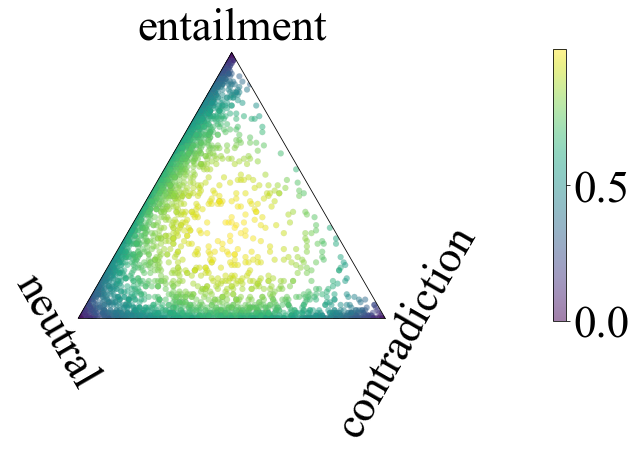

In [7]:
plt.figure(figsize=(10,10))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 45
ax = plt.subplot(projection="ternary")
ax.set_tlabel("entailment")
ax.set_llabel("neutral")
ax.set_rlabel("contradiction")
ax.tick_params(tick1On=False, tick2On=False, label1On=False, label2On=False)
sc  = ax.scatter(label_dist[:,0], label_dist[:,1], label_dist[:,2], c=entropy(label_dist, axis=1, base=3), cmap='viridis',  alpha=0.5, edgecolor='gray', linewidth = 0.1, rasterized=False)
plt.rcParams["font.size"] = 45
cbar = plt.colorbar(sc, ax=ax, pad=0.3, shrink=0.5, location="right")
# cbar.set_label('Entropy')
# os.makedirs(os.path.join("figures", "chaosNLI", "general"), exist_ok=True)  
# plt.savefig(os.path.join("figures", "chaosNLI", "general", "scatter_all_alpha.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

(0.0, 1.0)

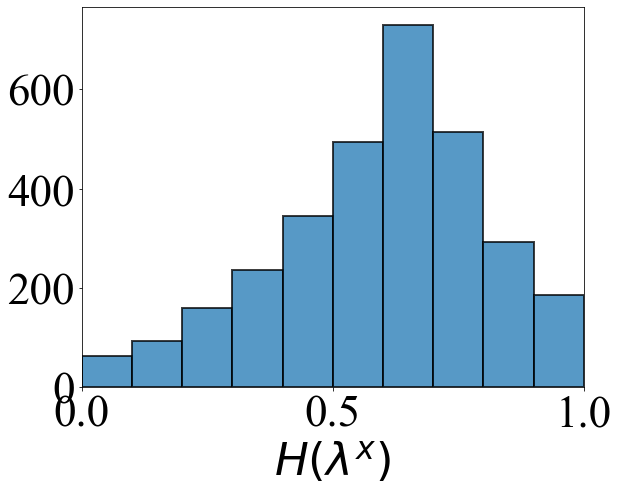

In [8]:
fig = plt.figure(figsize=(9,7))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 45
plt.hist(entropy(label_dist, axis=1, base=3), alpha=.75, edgecolor='k', linewidth=2)
plt.xlabel(r'$H(\lambda^x)$')
# plt.title("GT distributions")
plt.xlim([0,1])
# plt.savefig(os.path.join("figures", "chaosNLI", "general", "histogram.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)

In [29]:
with open(os.path.join("data", "chaosNLI", "embeddings", "snli.pkl"), 'rb') as f:
    snli = pickle.load(f)

with open(os.path.join("data", "chaosNLI", "embeddings", "mnli_m.pkl"), 'rb') as f:
    mnli = pickle.load(f)

embedding = np.concatenate((snli["embedding"], mnli["embedding"]), axis=0)
premise = np.concatenate((snli["premise"], mnli["premise"]), axis=0)
hypothesis = np.concatenate((snli["hypothesis"], mnli["hypothesis"]), axis=0)
label_dist = np.concatenate((snli["label_dist"], mnli["label_dist"]), axis=0)   
embedding.shape

(3113, 768)

# Some analysis on the results

In [9]:
exp_seed_str = "0"

alpha = 0.2

In [10]:
with open(os.path.join("results", "chaosNLI", exp_seed_str, "first_order_data.pkl"), 'rb') as f:
        fo_data = pickle.load(f)
with open(os.path.join("results", "chaosNLI", exp_seed_str, "second_order_data.pkl"), 'rb') as f:
        so_data = pickle.load(f)


calib_scores = fo_data["calib_score"]
lambda_hat_calib, lambda_hat_test, lambda_test, alpha_test= fo_data["lambda_hat_calib"], fo_data["lambda_hat_test"] , fo_data["lambda_test"], so_data["alpha_test"]

Define adaptive scores as well for first-order methods

In [11]:
methods = list(calib_scores.keys())
for m in methods:
    calib_scores[m+"_adaptive"] = calib_scores[m]/entropy(lambda_hat_calib, base=3, axis=1)

In [12]:
calib_scores["so"] = so_data["calib_score"]
dist_pred_test = tfd.Dirichlet(alpha_test)
mode_test = so_data["mode_test"]
methods = calib_scores.keys()

In [13]:
q = {}
for d in calib_scores.keys():
    q[d] = h.compute_quantile(calib_scores[d], alpha)

# Constructing the sets for all methods and all test points

In [15]:
idx_list = []
for k in range(500):
    if not np.mod(k,50):
        print(k)
    p = lambda_test[k]
    ph = lambda_hat_test[k]
    dist = dist_pred_test[k]
    
    idx = {}
    idx["tv"] = np.where((0.5*np.sum(np.abs(ph-simplex), axis=1))< q["tv"])[0]
    idx["tv_adaptive"] = np.where((0.5*np.sum(np.abs(ph-simplex), axis=1))/entropy(ph, base=3) < q["tv_adaptive"])[0]
    idx["kl"] = np.where(entropy(simplex, ph, base=2, axis=1)< q["kl"])[0]
    idx["kl_adaptive"] = np.where(entropy(simplex, ph, base=2, axis=1)/entropy(ph, base=3) < q["kl_adaptive"])[0]
    idx["inner"] = np.where((1-np.inner(ph, simplex))< q["inner"])[0]
    idx["inner_adaptive"] = np.where((1-np.inner(ph, simplex))/entropy(ph, base=3) < q["inner_adaptive"])[0]
    idx_ws = []
    idx_ws_adaptive = []
    for i in range(simplex.shape[0]):
        if wasserstein_distance([0,1,2], [0,1,2], ph, simplex[i]) < q["ws"]:
            idx_ws.append(i)
        if wasserstein_distance([0,1,2], [0,1,2], ph, simplex[i])/entropy(ph, base=3) < q["ws_adaptive"]:
            idx_ws_adaptive.append(i)
    idx["ws"] = idx_ws
    idx["ws_adaptive"] = idx_ws_adaptive

    probs = (dist_pred_test[k].prob(simplex)).numpy()
    mode_p = dist_pred_test[k].prob(mode_test[k]).numpy()
    idx["so"] = np.where(probs/mode_p >= (1-q["so"]))[0]
    idx_list.append(idx)

0
50
100
150
200
250
300
350
400
450


In [16]:
# os.makedirs(os.path.join("results", "chaosNLI", exp_seed_str), exist_ok=True)  
# with open(os.path.join("results", "chaosNLI", exp_seed_str, "all_credal_sets.pkl"), 'wb') as f:
#     pickle.dump(idx_list, f)

In [ ]:
with open(os.path.join("results", "chaosNLI", exp_seed_str, "all_credal_sets.pkl"), 'rb') as f:
        idx_list = pickle.load(f)

## Checking the coverage of all methods

In [17]:
cvg = {k: [] for k in list(methods)}
for i in range(lambda_hat_test.shape[0]):
    cvg["tv"].append(h.tv(lambda_hat_test[i], lambda_test[i]) <q["tv"])
    cvg["kl"].append(entropy(lambda_test[i], lambda_hat_test[i], base=2) <q["kl"])
    cvg["ws"].append(wasserstein_distance([0,1,2], [0,1,2], lambda_hat_test[i], lambda_test[i]) <q["ws"])
    cvg["inner"].append((1-np.inner(lambda_hat_test[i], lambda_test[i])) <q["inner"])
    cvg["tv_adaptive"].append(h.tv(lambda_hat_test[i], lambda_test[i])/entropy(lambda_hat_test[i], base=3) <q["tv_adaptive"])
    cvg["kl_adaptive"].append(entropy(lambda_test[i], lambda_hat_test[i], base=2)/entropy(lambda_hat_test[i], base=3) <q["kl_adaptive"])
    cvg["ws_adaptive"].append(wasserstein_distance([0,1,2], [0,1,2], lambda_hat_test[i], lambda_test[i])/entropy(lambda_hat_test[i], base=3) <q["ws_adaptive"])
    cvg["inner_adaptive"].append((1-np.inner(lambda_hat_test[i], lambda_test[i]))/entropy(lambda_hat_test[i], base=3) <q["inner_adaptive"])

    # probs = (dist_pred_test[i].prob(simplex)).numpy()
    # p = dist_pred_test[i].prob(lambda_test[i]).numpy()
    # cvg["so"].appendp/(np.max(probs)) >= (1-q["so"])
    mode_p = dist_pred_test[i].prob(mode_test[i]).numpy()
    p = dist_pred_test[i].prob(lambda_test[i]).numpy()
    cvg["so"].append(p/(mode_p) >= (1-q["so"]))

In [18]:
simplex_ent = entropy(simplex, base=3, axis=1)

In [19]:
TU = {m: [] for m in methods}
AU = {m: [] for m in methods}
EU = {m: [] for m in methods}
for i,p in enumerate(lambda_hat_test):
    for m in list(methods):
        if len(idx_list[i][m]):
            tu, au, eu = h.tu_au_eu(simplex_ent[idx_list[i][m]])
        else:
            tu, au, eu = np.nan, np.nan, np.nan
        TU[m].append(tu)
        AU[m].append(au)
        EU[m].append(eu)

# Vizualization of epistemic uncertainty hsitogram given differen methods

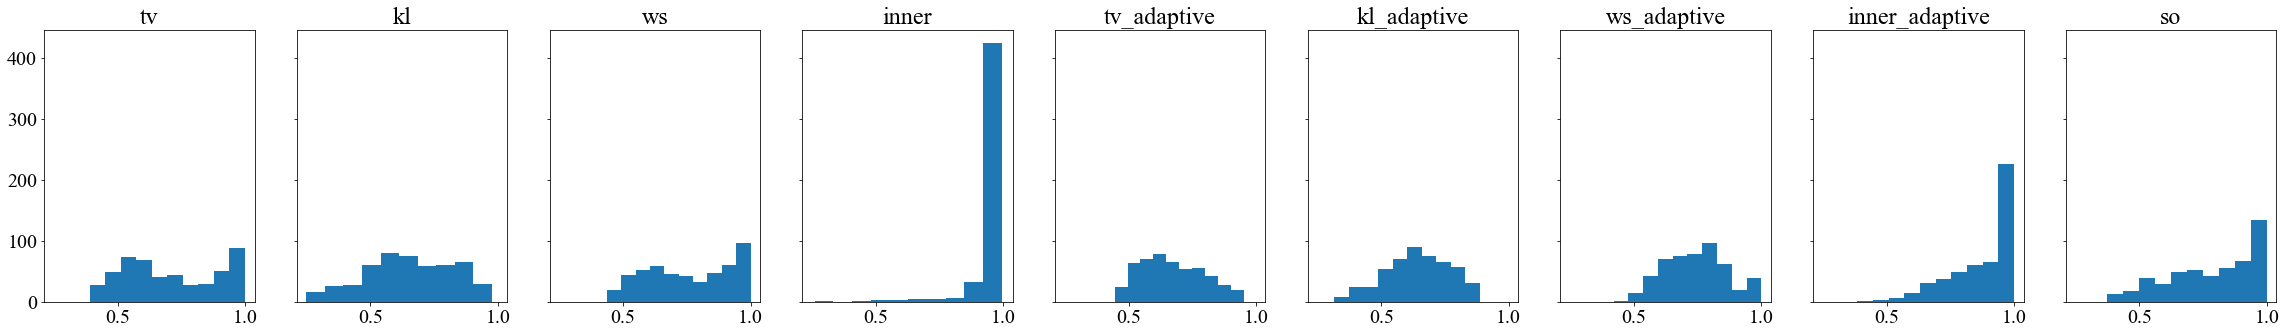

In [20]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, len(list(methods)), sharex=True, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):
    axs[i].hist(EU[m])
    axs[i].set_title(m)

In [20]:
for i, m in enumerate(list(methods)):
    fig = plt.figure(figsize=(9,7)) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 45
    plt.hist(EU[m], alpha=.75, edgecolor='k', linewidth=2)
    plt.xlabel("EU")
    # plt.title("GT distributions")
    plt.xlim([0,1])
    # os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "epistemic_histograms"), exist_ok=True)  
    # plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "epistemic_histograms", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    # plt.close()

# Vizualization of AU/EU plots given differen methods

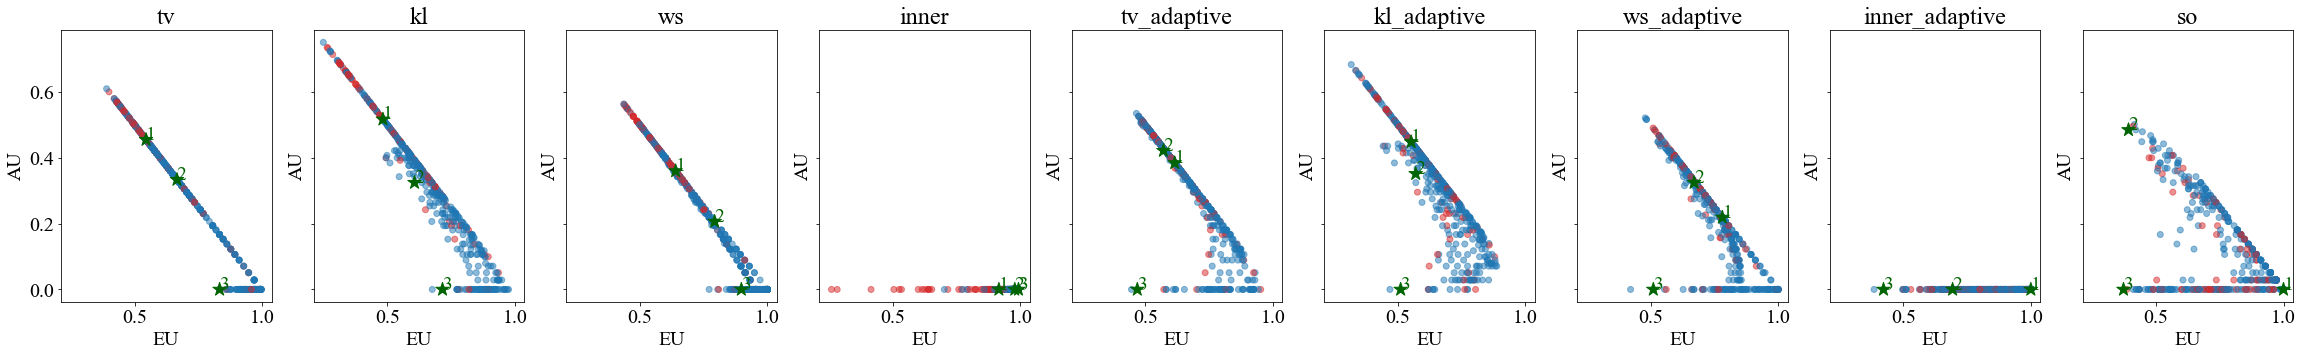

In [21]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=True, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):


    axs[i].scatter(EU[m], np.array(AU[m]), alpha=0.5, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]])
    axs[i].scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    for jj, j in enumerate([1, 42, 146]):
        axs[i].annotate(jj+1, (EU[m][j],AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("EU")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)


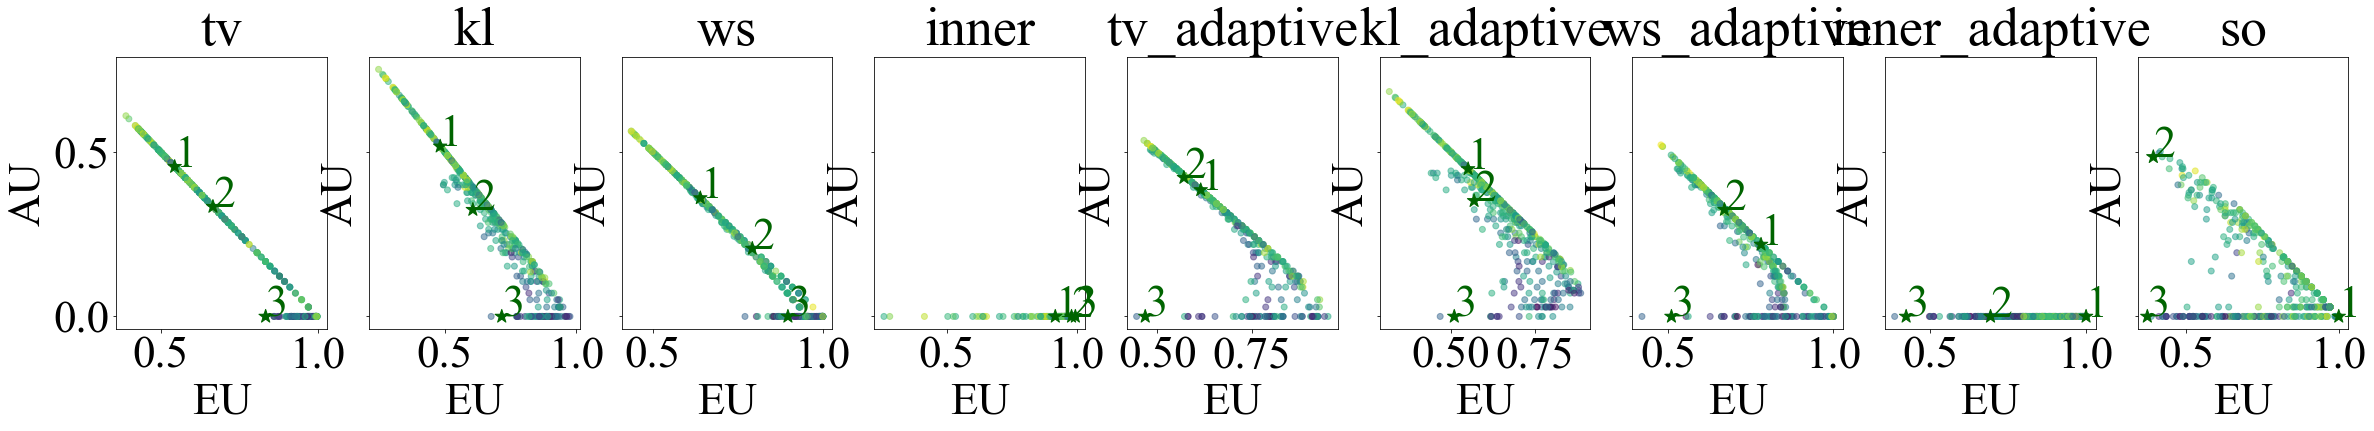

In [26]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):


    axs[i].scatter(EU[m], np.array(AU[m]), alpha=0.5, c=entropy(lambda_test, axis=1, base=3), cmap='viridis', )
    axs[i].scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    for jj, j in enumerate([1, 42, 146]):
        axs[i].annotate(jj+1, (EU[m][j],AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("EU")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)

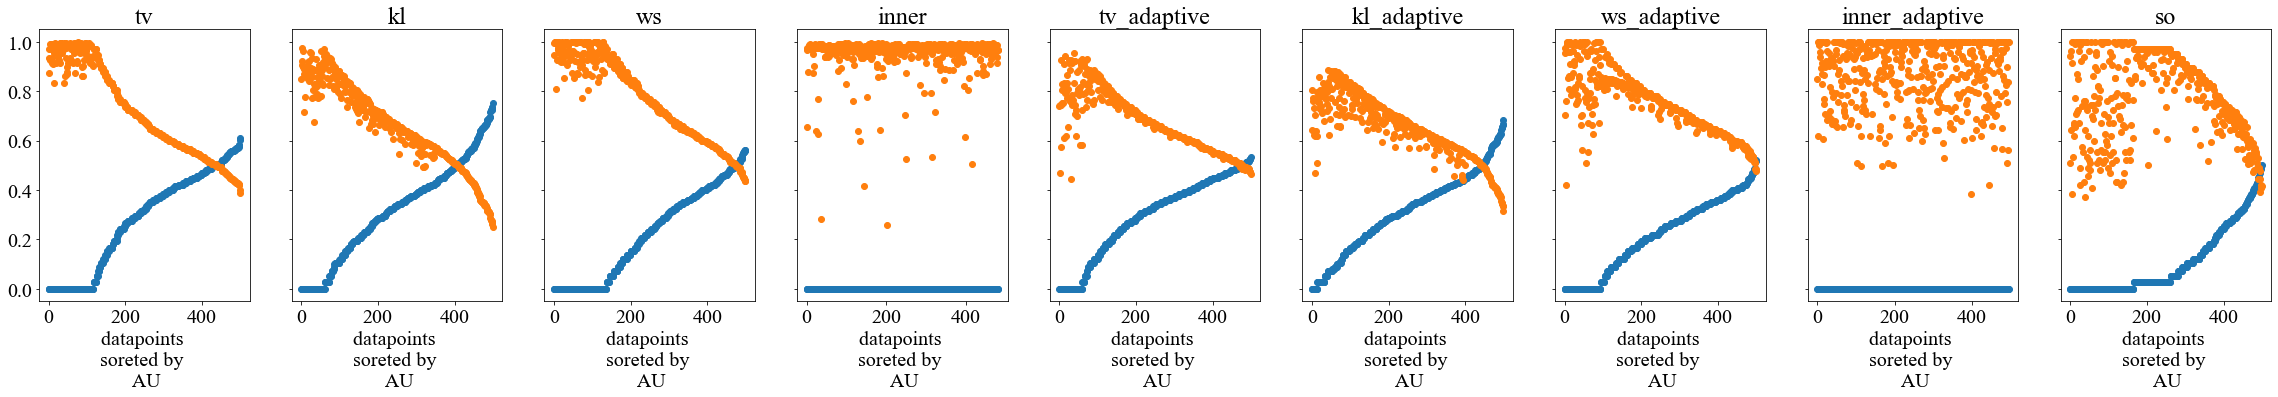

In [24]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(np.arange(len(lambda_test)), np.array(AU[m])[np.argsort(AU[m])], label="AU")
    axs[i].scatter(np.arange(len(lambda_test)), np.array(EU[m])[np.argsort(AU[m])], label="EU")
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    # for jj, j in enumerate([583, 302, 307]):
    #     axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("datapoints \nsoreted by \n AU")
    # axs[i].set_ylabel("AU")
    # axs[i].legend()
    axs[i].set_title(m)

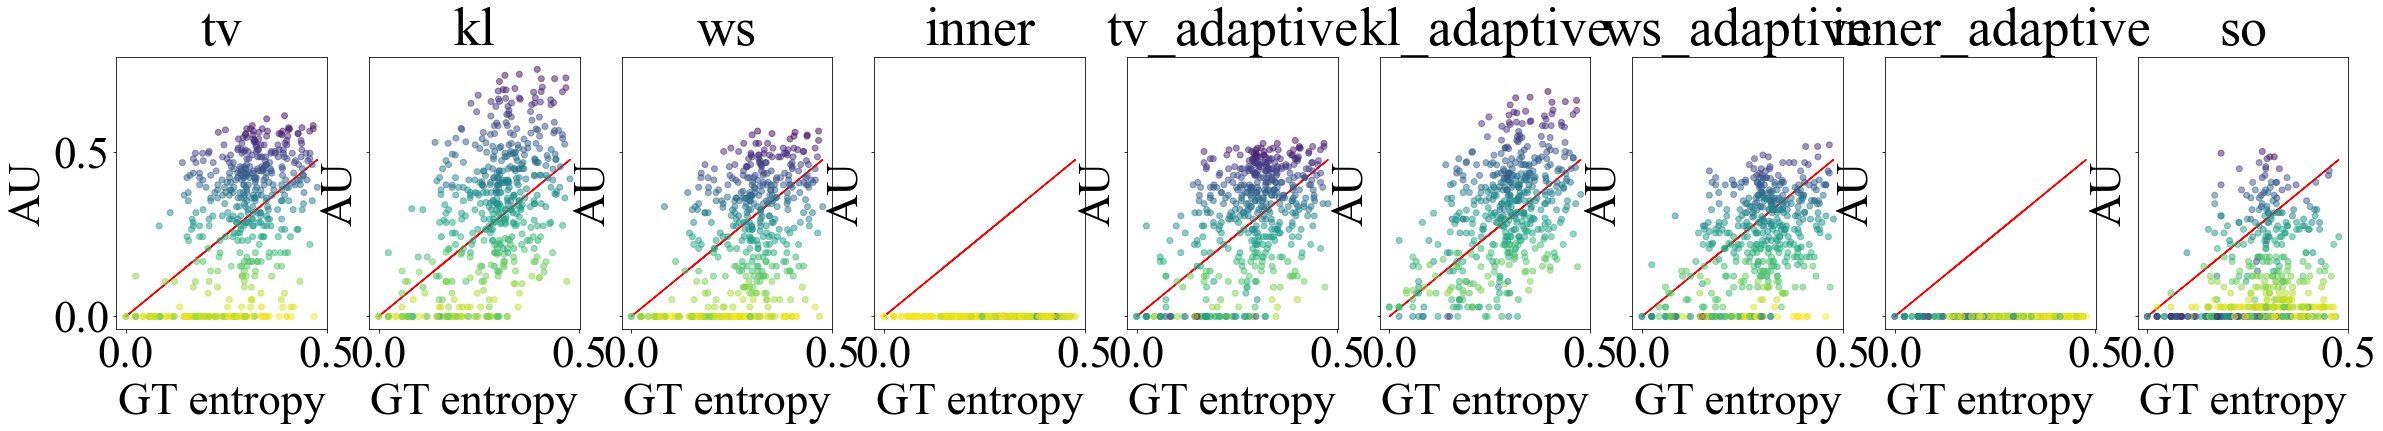

In [28]:
fig, axs = plt.subplots(1, len(list(methods)), sharex=False, sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):

    # idxs = np.where(entropy(lambda_test, axis=1, base=10)<0.1)[0]
    # axs[i].scatter(np.array(EU[m])[idxs], np.array(AU[m])[idxs], alpha=0.5, c=entropy(lambda_test, axis=1, base=10)[idxs], cmap='viridis', vmax=1)
   
    axs[i].scatter(entropy(lambda_test, axis=1, base=10), np.array(AU[m]), alpha=0.5, c=np.array(EU[m]), cmap='viridis', vmax=1, zorder=3)
    axs[i].plot(entropy(lambda_test, axis=1, base=10),entropy(lambda_test, axis=1, base=10), c='r')
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # axs[i].scatter(np.array(EU[m])[[583, 302, 307]], np.array(AU[m])[[583, 302, 307]], alpha=1, c=['w']*3, edgecolor='black', marker="o", s=500, linestyle='-')
    # for jj, j in enumerate([583, 302, 307]):
    #     axs[i].annotate(jj+1, (EU[m][j],0.05+AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("GT entropy")
    axs[i].set_ylabel("AU")
    axs[i].set_title(m)

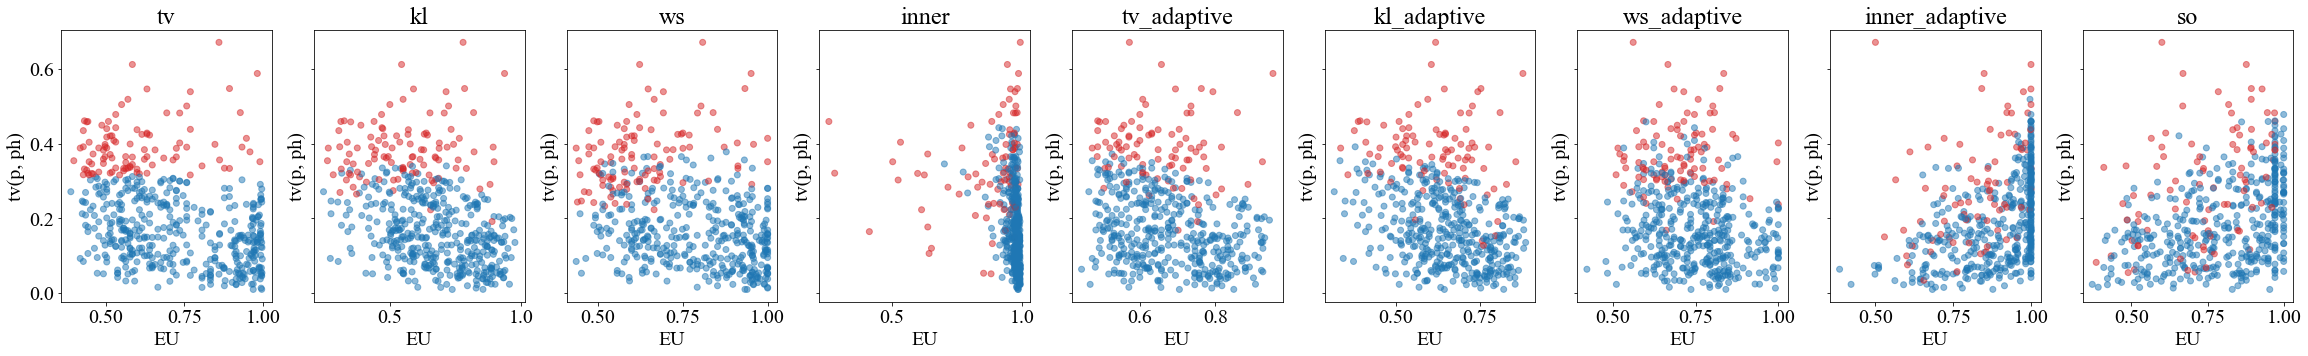

In [23]:
fig, axs = plt.subplots(1, len(list(methods)), sharey=True, figsize=(40,5))
for i, m in enumerate(list(methods)):


    axs[i].scatter(EU[m], (0.5*np.sum(np.abs(lambda_hat_test-lambda_test), axis=1)), alpha=0.5, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]])
    # axs[i].scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['darkgreen']*3, marker="*", s=200)
    # for jj, j in enumerate([1, 42, 146]):
    #     axs[i].annotate(jj+1, (EU[m][j],AU[m][j]), c="darkgreen")

    
    axs[i].set_xlabel("EU")
    axs[i].set_ylabel("tv(p, ph)")
    axs[i].set_title(m)

In [ ]:
for i, m in enumerate(list(methods)):
    fig = plt.figure(figsize=(7,7)) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 45
    # plt.scatter(EU[m], np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
    sc = plt.scatter(EU[m], np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=entropy(lambda_test, axis=1, base=3), cmap='viridis', vmax=1, s=200, zorder=3)
    # plt.scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['gold']*3, marker="*", s=300,edgecolor='black', linewidth = 0.5)
    sc2= plt.scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, marker="o", s=800,edgecolor='k', linewidth = 1, zorder=3)
    sc2.set_facecolor("none")
    for jj, j in enumerate([1, 42, 146]):
        plt.annotate(jj+1, (EU[m][j]-0.025,0.05+AU[m][j]), c="k")
    plt.xlabel("EU")
    plt.ylabel("AU")
    plt.xticks([0, 0.5, 1])

# Set y-axis tick values
    plt.yticks([0, 0.5, 1])
    plt.xlim([0,1.1])
    plt.ylim([-.10,1])
    # os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_EU"), exist_ok=True)  
    # plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_EU", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    # plt.close()


In [100]:
# for i, m in enumerate(list(methods)):
#     fig = plt.figure(figsize=(7,7)) 
#     plt.rcParams["font.family"] = "Times New Roman"
#     plt.rcParams["font.size"] = 45
#     plt.scatter(EU[m], np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
#     plt.scatter(np.array(EU[m])[[1, 42, 146]], np.array(AU[m])[[1, 42, 146]], alpha=1, c=['gold']*3, marker="*", s=300,edgecolor='black', linewidth = 0.5)
#     for jj, j in enumerate([1, 42, 146]):
#         plt.annotate(jj+1, (EU[m][j]-0.02,0.025+AU[m][j]), c="k")
#     plt.xlabel("EU")
#     plt.ylabel("AU")
#     plt.xticks([0, 0.5, 1])

# # Set y-axis tick values
#     plt.yticks([0, 0.5, 1])
#     plt.xlim([0,1.1])
#     plt.ylim([-.10,1])
#     os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_EU"), exist_ok=True)  
#     plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_EU", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
#     plt.close()

# Vizualization of AU/Entropy(lambda) plots given differen methods

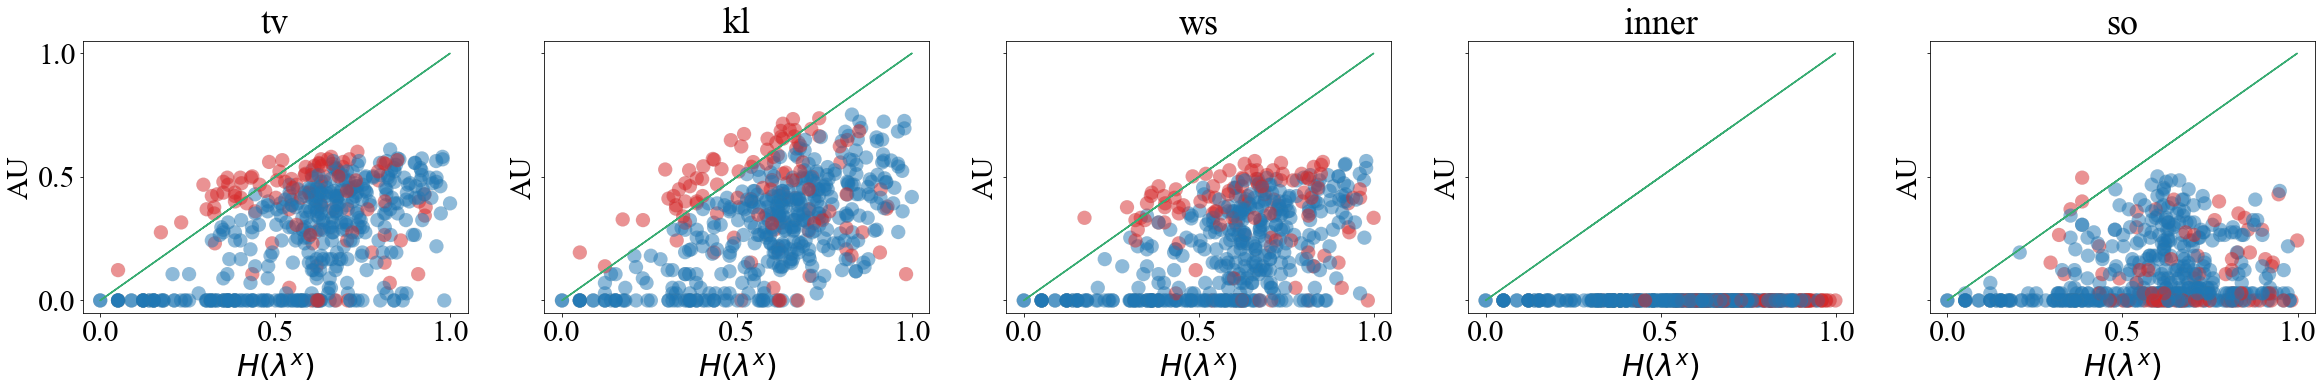

In [113]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==1:
            axs[i].scatter(entropy(lambda_test, axis=1, base=3), np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
            axs[i].plot(entropy(lambda_test, axis=1, base=3), entropy(lambda_test, axis=1, base=3), c=credal_color)
            axs[i].set_xlabel(r'$H(\lambda^x)$')
            axs[i].set_ylabel("AU")
            axs[i].set_title(m)
            i = i + 1

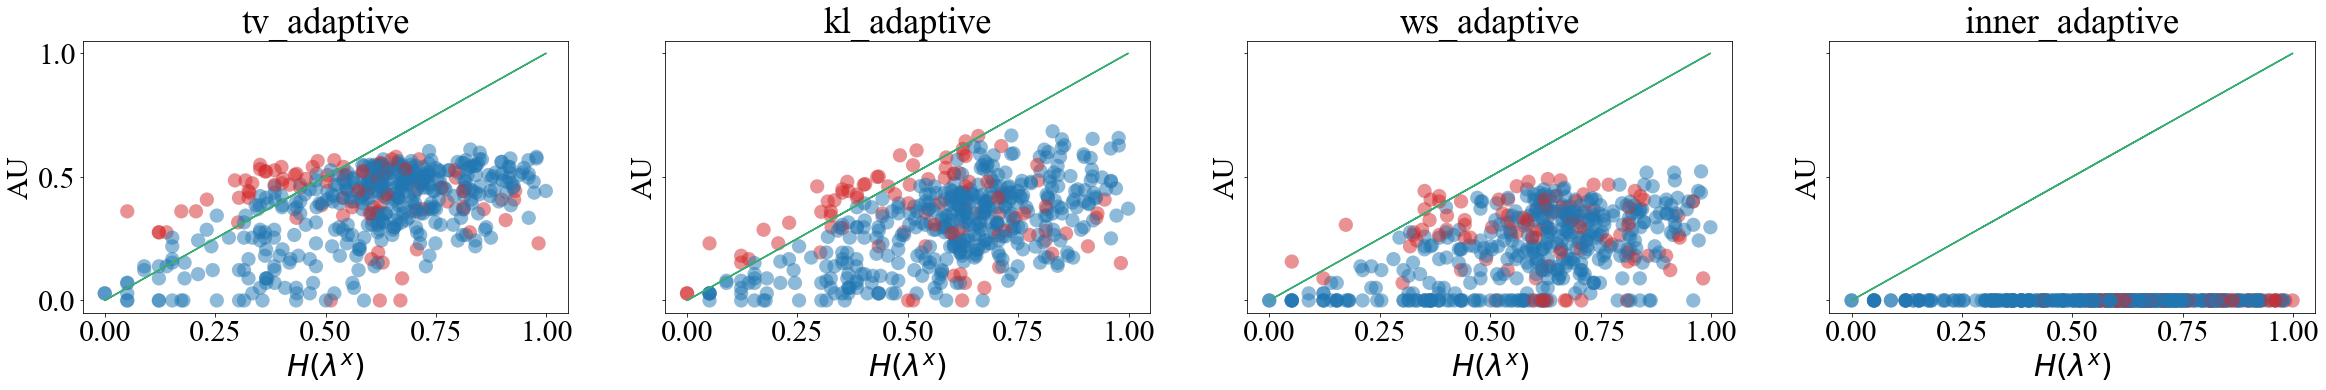

In [115]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==2:
            axs[i].scatter(entropy(lambda_test, axis=1, base=3), np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)
            axs[i].plot(entropy(lambda_test, axis=1, base=3), entropy(lambda_test, axis=1, base=3), c=credal_color)
            axs[i].set_xlabel(r'$H(\lambda^x)$')
            axs[i].set_ylabel("AU")
            axs[i].set_title(m)
            i = i + 1

In [116]:
for i, m in enumerate(list(methods)):
    fig = plt.figure(figsize=(7,7)) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 45
    plt.scatter(entropy(lambda_test, axis=1, base=3), np.array(AU[m]), alpha=0.5, edgecolor='gray', linewidth = 0.1, c=['tab:red' if val == 0 else 'tab:blue' for val in cvg[m]], s=200)

    plt.xlabel(r'$H(\lambda^x)$')
    plt.ylabel("AU")
    plt.xticks([0, 0.5, 1])

# Set y-axis tick values
    plt.yticks([0, 0.5, 1])
    plt.xlim([0,1])
    plt.ylim([-.10,1])
    os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_entropy_test"), exist_ok=True)  
    plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "AU_entropy_test", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
    plt.close()

# Vizualization of scores vs entropy of the predicted distributions, showing why our adaptive method should make sense

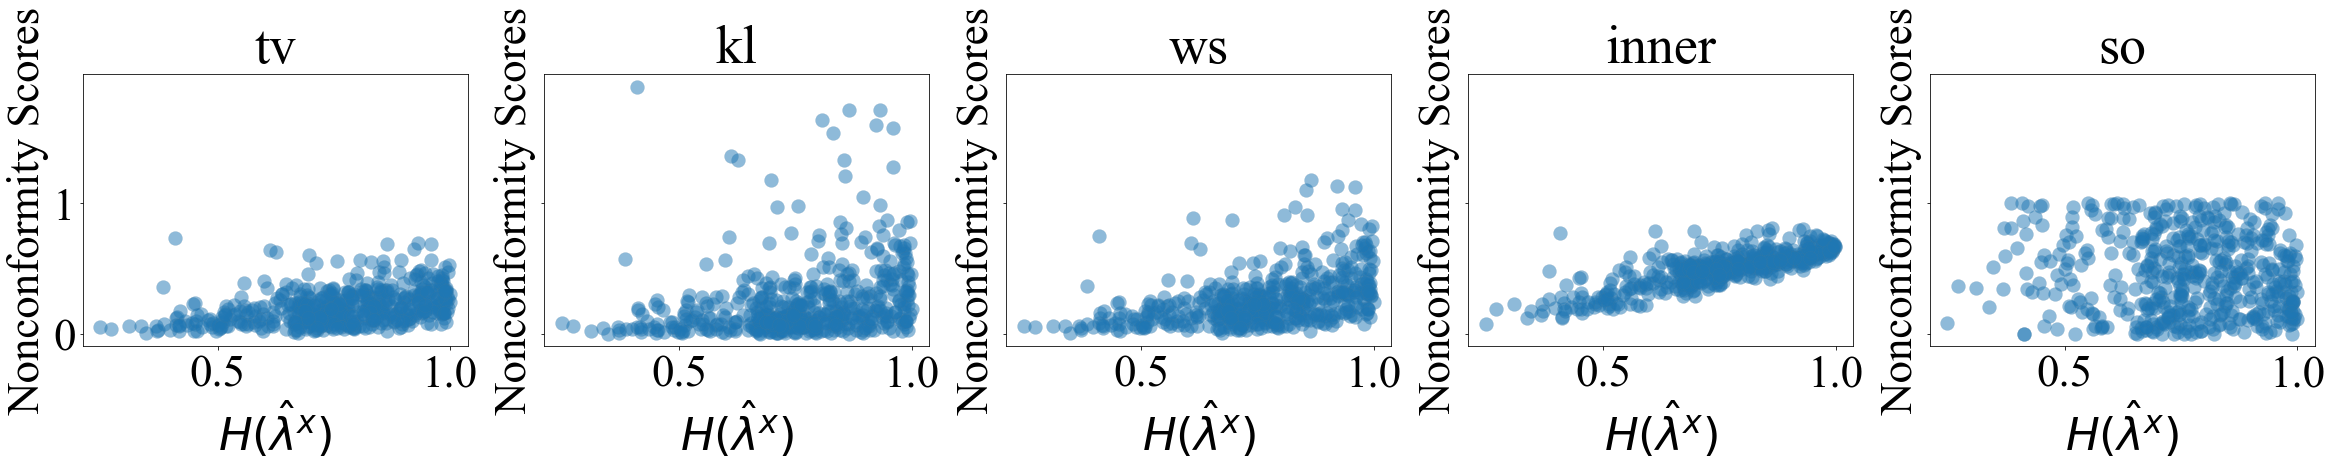

In [101]:
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==1:
            axs[i].scatter(entropy(lambda_hat_calib, axis=1, base=3), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
            axs[i].set_xlabel(r'$H(\hat{\lambda}^x)$')
            axs[i].set_ylabel("Nonconformity Scores")
            axs[i].set_title(m)
            i = i + 1

In [102]:
for i, m in enumerate(list(methods)):
    if len(m.split('_'))==1:
        fig = plt.figure(figsize=(7,7)) 
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 30
        plt.scatter(entropy(lambda_hat_calib, axis=1, base=3), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
        plt.xlabel("$H(\hat{\lambda}^x)$")
        plt.ylabel("Nonconformity Scores")
        plt.xlim([0,1])
        # plt.ylim([-.10,1])
        os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib"), exist_ok=True)  
        plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        plt.close()

# Vizualization of adaptive scores vs entropy of the predicted distributions, showing that our method works

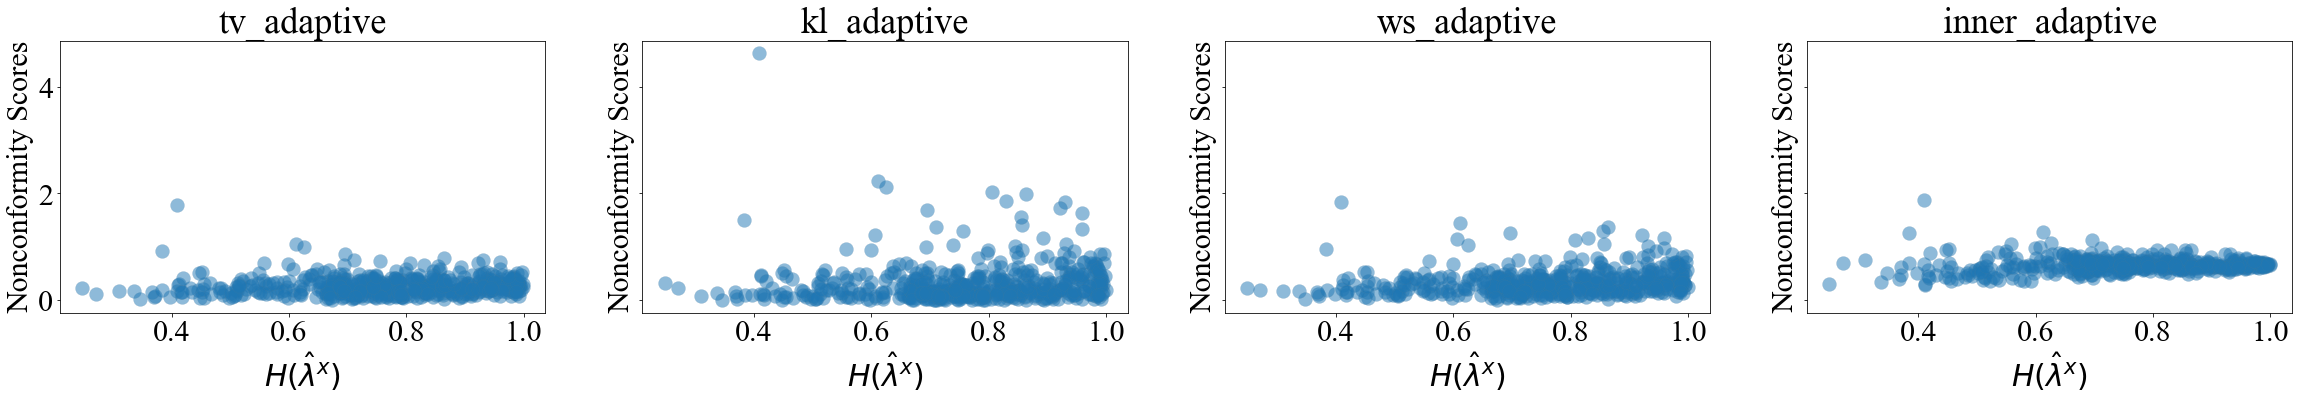

In [105]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(40,5))
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==2:
            axs[i].scatter(entropy(lambda_hat_calib, axis=1, base=3), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
            axs[i].set_xlabel(r'$H(\hat{\lambda}^x)$')
            axs[i].set_ylabel("Nonconformity Scores")
            axs[i].set_title(m)
            i = i + 1

In [106]:
for i, m in enumerate(list(methods)):
    if len(m.split('_'))==2:
        fig = plt.figure(figsize=(7,7)) 
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams["font.size"] = 30
        plt.scatter(entropy(lambda_hat_calib, axis=1, base=3), calib_scores[m], alpha=0.5, edgecolor='gray', linewidth = 0.1, s=200)
        plt.xlabel("$H(\hat{\lambda}^x)$")
        plt.ylabel("Nonconformity Scores")
        plt.xlim([0,1])
        # plt.ylim([-.10,1])
        os.makedirs(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib"), exist_ok=True)  
        plt.savefig(os.path.join("figures", "chaosNLI", "uncertainty", "seed_"+exp_seed_str, "scores_entropy_calib", m+".pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
        plt.close()

# Finding interesting examples to show in the paper

In [108]:
np.argmin(EU["kl_adaptive"])

395

In [132]:
k = 1

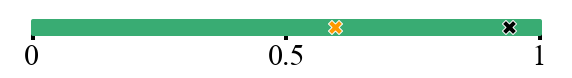

In [133]:
m="so"
plot_interval(AU[m][k], TU[m][k], entropy(lambda_test[k], base=3), entropy(dist_pred_test[k].mean().numpy(), base=3))
plt.savefig(os.path.join("figures", "chaosNLI", "seed_"+exp_seed_str+"_k_"+str(k), "alpha_"+str(alpha), "unc_interval.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)


c:\Users\Alireza\.conda\envs\rul_unc\lib\site-packages\mpltern\_ternary_parsers.py:35: UserWarning: The following kwargs were not used by contour: 'label'
  return f(ax, *args, **kwargs)


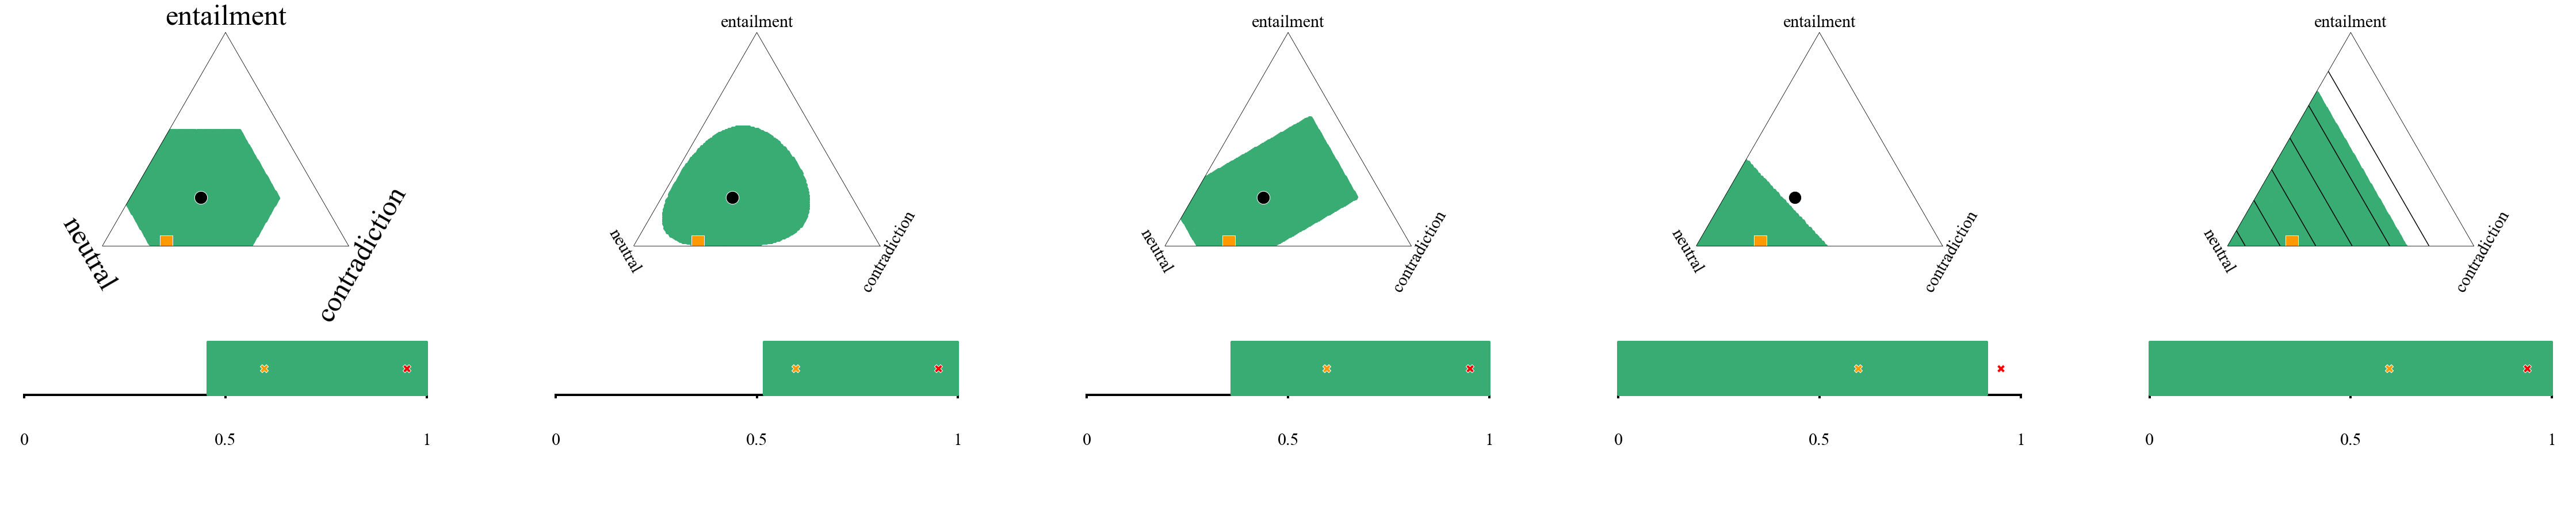

In [119]:
p = lambda_test[k]
ph = lambda_hat_test[k]
a = alpha_test[k]
fig = plt.figure(figsize=(80,15))
plt.rcParams["font.size"] = 50
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==1:
            ax = fig.add_subplot(2, 5, i + 1, projection='ternary')
            if m=="so":
                  my_ternery(ax, idx_list[k][m], p, alpha=a)
                  ax2 = fig.add_subplot(2, 5, i + 6)
                  plot_interval(AU[m][k], TU[m][k], entropy(p, base=3), entropy(dist_pred_test[k].mean(), base=3), ax=ax2)
            else: 
                  my_ternery(ax, idx_list[k][m], p, ph=ph)
                  ax2 = fig.add_subplot(2, 5, i + 6)
                  plot_interval(AU[m][k], TU[m][k], entropy(p, base=3), entropy(ph, base=3), ax=ax2)
            i = i + 1

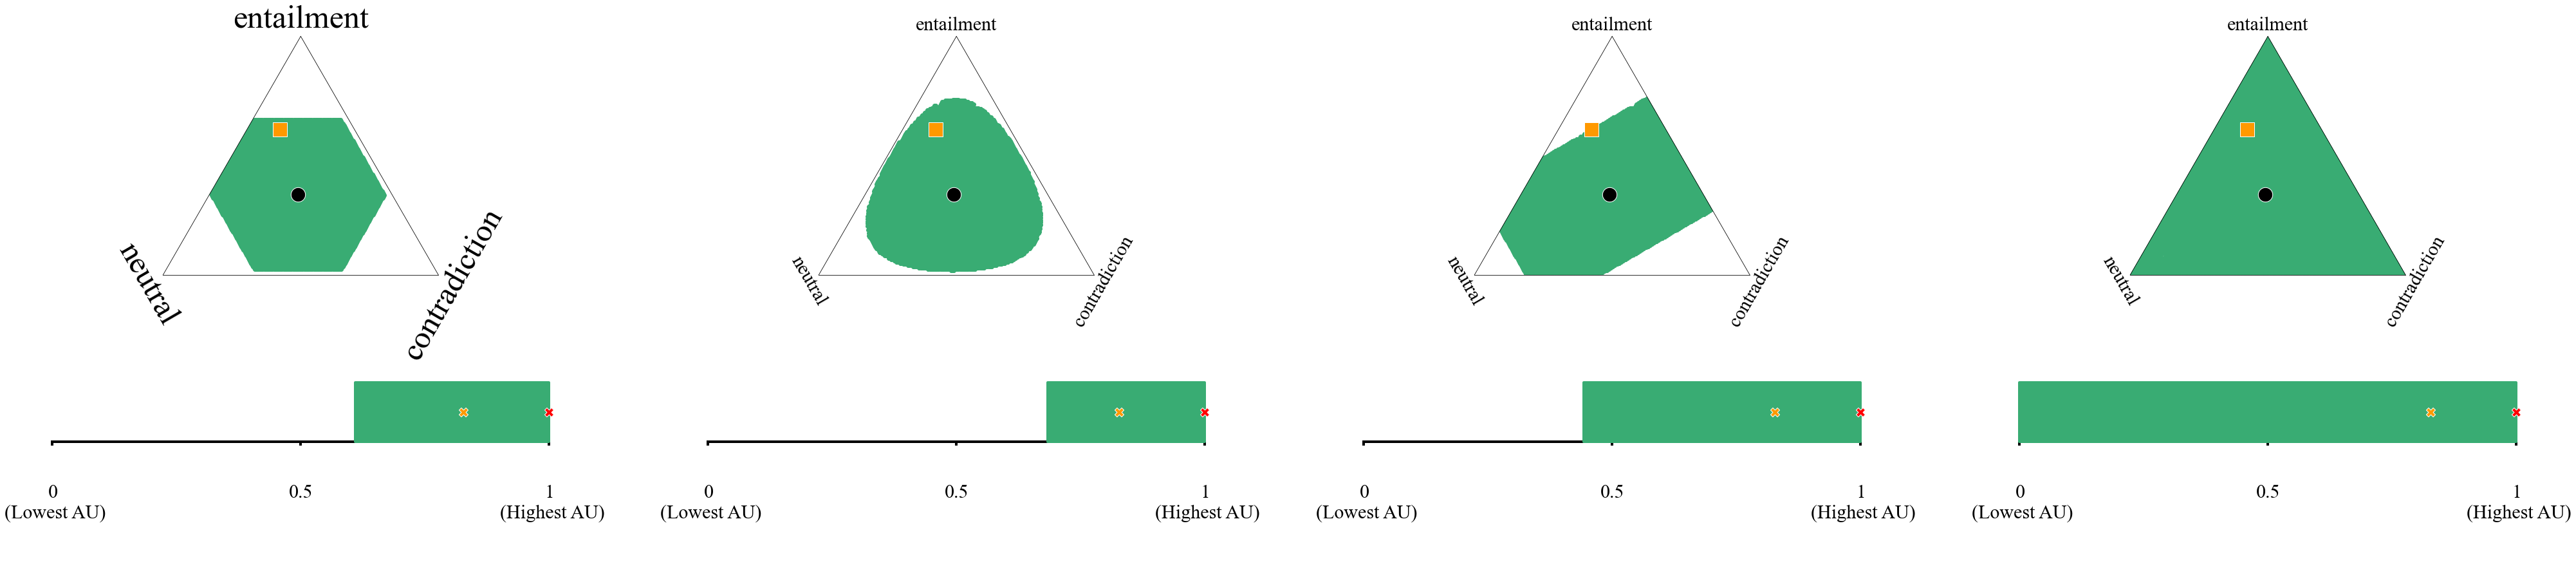

In [111]:
fig = plt.figure(figsize=(70,15))
plt.rcParams["font.size"] = 50
plt.rcParams["font.family"] = "Times New Roman"
i = 0
for m in list(methods):
    if len(m.split('_'))==2:
            ax = fig.add_subplot(2, 4, i + 1, projection='ternary')
            if m=="so":
                  my_ternery(ax, idx_list[k][m], p, alpha=a)
            else: 
                  my_ternery(ax, idx_list[k][m], p, ph=ph)
                  ax2 = fig.add_subplot(2, 4, i + 5)
                  plot_interval(AU[m][k], TU[m][k], entropy(p, base=3), entropy(ph, base=3), ax=ax2)
            i = i + 1

Also provide intervals for already existing plots in the paper

In [135]:
for k in [2, 6, 156]:
    for m in list(methods):
        if len(m.split('_'))==1:
            if m=="so":
                plot_interval(AU[m][k], TU[m][k], entropy(lambda_test[k], base=3), entropy(dist_pred_test[k].mean().numpy(), base=3))
            else: 
                plot_interval(AU[m][k], TU[m][k], entropy(lambda_test[k], base=3), entropy(lambda_hat_test[k], base=3))
            plt.savefig(os.path.join("figures", "chaosNLI", "seed_"+exp_seed_str+"_k_"+str(k), "alpha_"+str(alpha), m+"_unc_interval.pdf"), format='pdf', bbox_inches='tight', pad_inches=0)
            plt.close()